# Classification, Localization, Segmentation for PASCAL VOC 2012


**Goals**
* Build and train a **classification**, **localization** and **Segmentation** network.
* Showcase the flexibility of neural network with several, heterogenous outputs (bounding boxes and classes).
* Lastly we will try to create a **Multi-Model network** for segmentation task too, to output (Mask, bounding boxes and classes).

**Dataset**
* PASCAL VOC 2012 from [Kaggle](https://www.kaggle.com/huanghanchina/pascal-voc-2012)

We will build the model in three consecutive steps:
* **Extract label annotations** from a standard Object Detection dataset, namely **PASCAL VOC 2012**.
* Use a pre-trained image classification model (namely ResNet50) to **precompute convolutional representations** with shape $(7, 7, 2048)$ for all the images in the object detection training set.
* **Design and train a baseline object detection model with two heads** to predict:
    - class labels
    - bounding box coordinates of a single detected object in the image
    
Note that the simple baseline model presented here will only detect a single occurence of a class per image. More work would be required to detect all possible object occurences in the images. Take a look at the [slides](https://m2dsupsdlclass.github.io/lectures-labs/slides/05_conv_nets_2/index.html#1) for references to states of the art object detection models such as [Faster RCNN](https://arxiv.org/abs/1506.01497) and [YOLO9000](https://arxiv.org/abs/1612.08242).

In [ ]:
# Load packages
import h5py
import os

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET

from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.layers import Convolution2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, Input
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error
from tensorflow.keras.models import Model

##Getting Data from Kaggle using API

In [ ]:
!wget https://raw.githubusercontent.com/ozzmanmuhammad/Extras/main/DL_Extras/dataset_downloader.py

--2023-04-04 04:05:03--  https://raw.githubusercontent.com/ozzmanmuhammad/Extras/main/DL_Extras/dataset_downloader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225 (1.2K) [text/plain]
Saving to: ‘dataset_downloader.py’

dataset_downloader. 100%[===================>]   1.20K  --.-KB/s    in 0s      

2023-04-04 04:05:04 (56.1 MB/s) - ‘dataset_downloader.py’ saved [1225/1225]



In [ ]:
from dataset_downloader import Download_Kaggle_Dataset

In [ ]:
Download_Kaggle_Dataset('huanghanchina/pascal-voc-2012', extraction_path = "/content/", type='dataset')

## Loading img, annotations & masks

We will be using PASCAL VOC 2012, a dataset widely used in detection and segmentation [link](http://host.robots.ox.ac.uk/pascal/VOC/). To lower memory footprint and training time, we will only use five classes: *dog*, *cat*, *bus*, *car*, *aeroplane*. Here are the first steps:
* Load the annotations file from PASCAL VOC and parse it (xml files)
* Keep only the annotations we are interested in, and containing a single object
* Pre-compute ResNet conv5c from the corresponding images

In [ ]:
IMG_DIR = '/content/VOC2012/JPEGImages/'
ANNOTATION_DIR = '/content/VOC2012/Annotations'
MASK_DIR = '/content/VOC2012/SegmentationClass'
OBJ_MASK_DIR = '/content/VOC2012/SegmentationObject'

In PASCAL VOC 2012, masks for segmentation are given for only few images which we can see below.
So if we want to perform segmentation of same images we'll have to filter only those images.

In [ ]:
print(f'Total Images: {len(os.listdir(IMG_DIR))}.')
print(f'Total Annotations: {len(os.listdir(ANNOTATION_DIR))}.')
print(f'Total Masks: {len(os.listdir(MASK_DIR))}.')

Total Images: 17125.
Total Annotations: 17125.
Total Masks: 2913.


### Understanding Annotations

Tree structure of single XML annotation file.

In [ ]:
tree = ET.parse(os.path.join(ANNOTATION_DIR, os.listdir(ANNOTATION_DIR)[2100]))

In [ ]:
root = tree.getroot()
root.tag

'annotation'

In [ ]:
for child in root:
    print(child.tag, child.attrib)

filename {}
folder {}
object {}
segmented {}
size {}
source {}


In [ ]:
[elem.tag for elem in root.iter()]

In [ ]:
print(ET.tostring(root, encoding='utf8').decode('utf8'))

<?xml version='1.0' encoding='utf8'?>
<annotation>
	<filename>2009_001368.jpg</filename>
	<folder>VOC2012</folder>
	<object>
		<name>dog</name>
		<bndbox>
			<xmax>381</xmax>
			<xmin>124</xmin>
			<ymax>333</ymax>
			<ymin>78</ymin>
		</bndbox>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
	</object>
	<object>
		<name>dog</name>
		<bndbox>
			<xmax>211</xmax>
			<xmin>21</xmin>
			<ymax>333</ymax>
			<ymin>81</ymin>
		</bndbox>
		<difficult>0</difficult>
		<occluded>1</occluded>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
	</object>
	<segmented>0</segmented>
	<size>
		<depth>3</depth>
		<height>333</height>
		<width>500</width>
	</size>
	<source>
		<annotation>PASCAL VOC2009</annotation>
		<database>The VOC2009 Database</database>
		<image>flickr</image>
	</source>
</annotation>


In [ ]:
root = tree.getroot()
for child in root:
  print({x.tag for x in root.findall('./object/*')})


{'name', 'pose', 'difficult', 'bndbox', 'point', 'actions'}
{'name', 'pose', 'difficult', 'bndbox', 'point', 'actions'}
{'name', 'pose', 'difficult', 'bndbox', 'point', 'actions'}
{'name', 'pose', 'difficult', 'bndbox', 'point', 'actions'}
{'name', 'pose', 'difficult', 'bndbox', 'point', 'actions'}
{'name', 'pose', 'difficult', 'bndbox', 'point', 'actions'}


In [ ]:
tree.find('.//height').text, float(tree.find('.//height').text), int(tree.find('.//height').text),

('500', 500.0, 500)

In [ ]:
int(float(tree.find('.//height').text))

500

### Understanding Segmentations Masks

Two type of segmentation is avaliable in PASCAL VOC dataset:

*   Object Based, aka "Instance based segmentation"
*   Class Based, aka "Sementic segmentation"

For this purpose we'll do sementic segmentation.


In [ ]:
os.listdir(MASK_DIR)[0]

'2011_000379.png'

In [ ]:
# mask visualization

def mask_visualization(mask_list, mask_dir_path, img_dir_path, sample_size = 12):
  plt.figure(figsize = (10, 10))
  for idx, mask_name in enumerate(np.random.choice(mask_list, sample_size), start = 1):
    plt.subplot( int((sample_size / 5) + 1), 5, idx)
    mask = imread(os.path.join(mask_dir_path, mask_name))
    img = imread(os.path.join(img_dir_path, mask_name.split('.')[0] + '.jpg'))
    plt.imshow(img)
    plt.imshow(mask, alpha = 0.6)
    plt.axis(False)

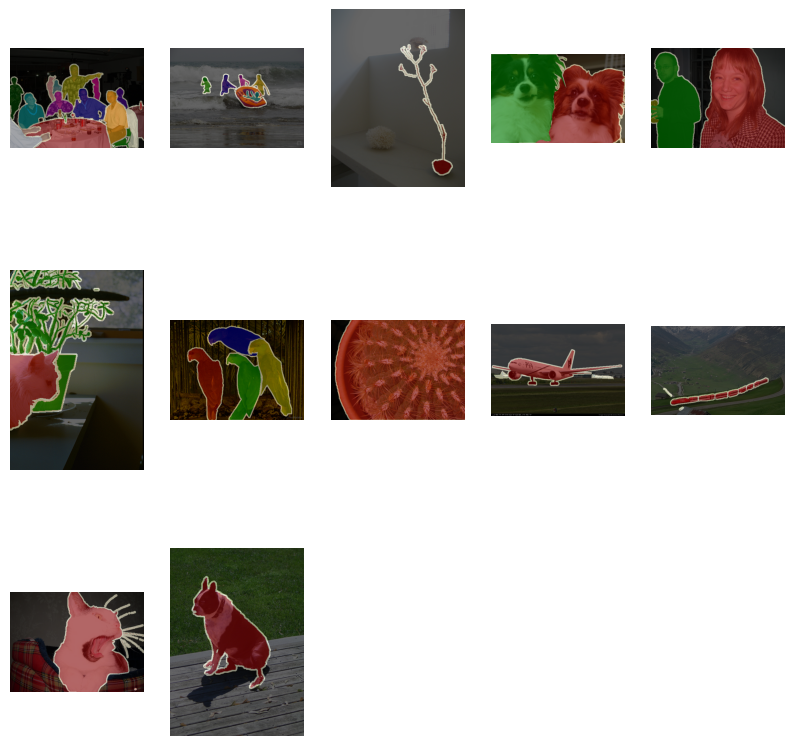

In [ ]:
mask_visualization(os.listdir(OBJ_MASK_DIR), OBJ_MASK_DIR, IMG_DIR)

### Parse Annotations

We'll parse the annotation and will select only few classes from

**20 classes:**


*   *Person:* person
*  *Animal:* bird, cat, cow, dog, horse, sheep
*  *Vehicle:* aeroplane, bicycle, boat, bus, car, motorbike, train
*  *Indoor:* bottle, chair, dining table, potted plant, sofa, tv/monitor

In [ ]:
class_filters = ['dog', 'cat', 'bird', 'cow', 'horse']

In [ ]:
# Parse the xml annotation file and retrieve the path to each image, its size and annotations
def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    """
    tree = ET.parse(filename)
    objects = tree.findall('./object')
    size = (int(float(tree.find('.//width').text)), int(float(tree.find('.//height').text)))
    fname = tree.find('./filename').text
    dicts = [{obj.find('name').text: [int(float(obj.find('bndbox/xmin').text)),
                                      int(float(obj.find('bndbox/ymin').text)),
                                      int(float(obj.find('bndbox/xmax').text)),
                                      int(float(obj.find('bndbox/ymax').text))]}
             for obj in objects]
    return {'size': size, 'filename': fname, 'objects': dicts}

In [ ]:
%%time
# Filters annotations and masks, keeping only those we are interested in.
# We only keep images in which there is a single item
annotations = []
masks = []

idx2labels = {k: v for k, v in enumerate(class_filters)}
labels2idx = {v: k for k, v in idx2labels.items()}

for filename in sorted(os.listdir(ANNOTATION_DIR)):
    annotation = extract_xml_annotation(os.path.join(ANNOTATION_DIR, filename))

    new_objects = []
    for obj in annotation['objects']:
        if list(obj.keys())[0] in class_filters:
            new_objects.append(obj)

    if len(new_objects) == 1:
        annotation['class'] = list(new_objects[0].keys())[0]
        annotation['bbox'] = list(new_objects[0].values())[0]
        annotation.pop('objects')

        if os.path.exists(os.path.join(MASK_DIR, annotation['filename'].split('.')[0] + ".png")):
            annotations.append(annotation)
            masks.append(annotation['filename'].split('.')[0] + ".png")

CPU times: user 1.69 s, sys: 263 ms, total: 1.95 s
Wall time: 1.95 s


In [ ]:
print(f'Number of images with masks: {len(masks)}.')
print(f'Number of images with annotations: {len(annotations)}.')
print(f'Example contents of one annotation: {annotations[0]}')
print(f'Correspondence between indices and labels: {idx2labels}')

Number of images with masks: 754.
Number of images with annotations: 754.
Example contents of one annotation: {'size': (500, 375), 'filename': '2007_000063.jpg', 'class': 'dog', 'bbox': [123, 115, 379, 275]}
Correspondence between indices and labels: {0: 'dog', 1: 'cat', 2: 'bird', 3: 'cow', 4: 'horse'}


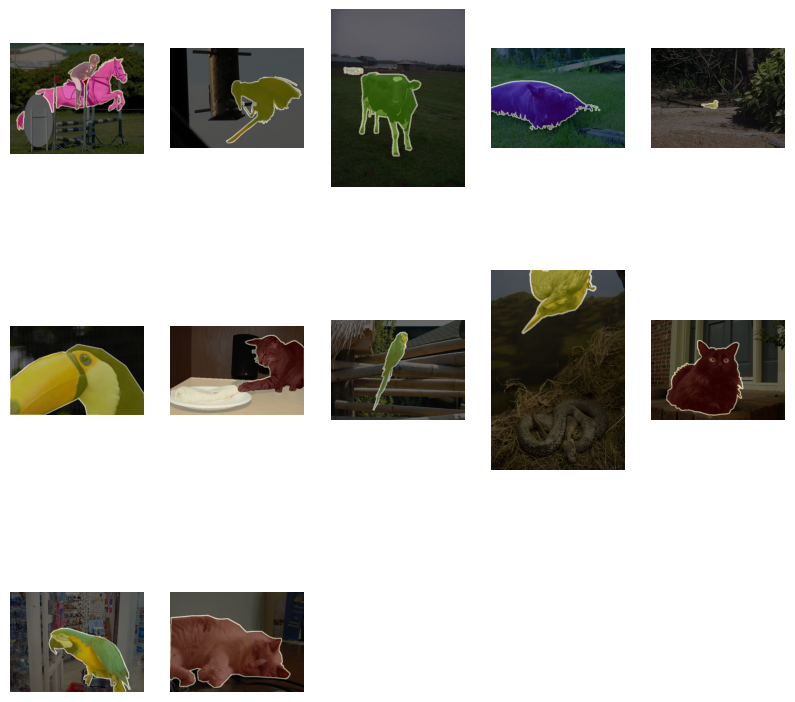

In [ ]:
mask_visualization(masks, MASK_DIR, IMG_DIR)

In [ ]:
img_path = os.path.join(MASK_DIR, masks[6])
from PIL import Image
colors = Image.open(img_path).convert('RGB').getcolors()
mask = imread(img_path)

In [ ]:
colors

[(4246, (224, 224, 192)), (21937, (64, 0, 0)), (161317, (0, 0, 0))]

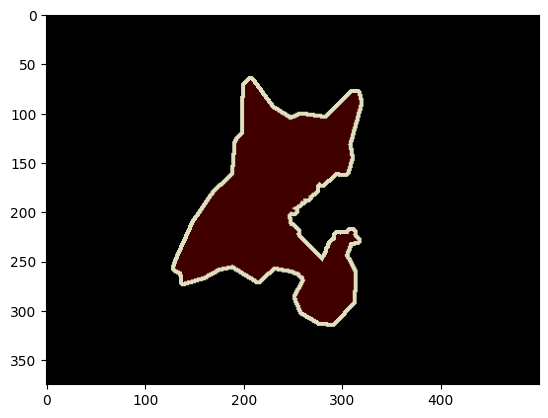

In [ ]:
plt.imshow(mask)

<h3> 1: Dog, 2: Bird, 3:Horse, 4:Cow, 5:Cat </h3>

In [ ]:
filter_cls_colors = [(64, 0, 128), (128, 128, 0), (192, 0, 128), (64, 128, 0)]

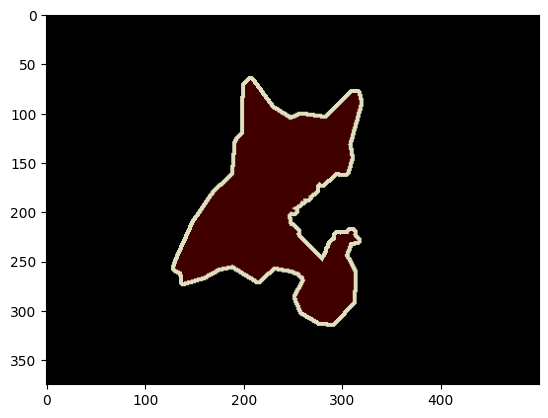

In [ ]:
r2, g2, b2 = 0, 0, 0 # Value that we want to replace it with

if len(colors) > 3:
  for color in colors:
    if color[1] not in filter_cls_colors:

      r1, g1, b1 = color[1] # Original value

      red, green, blue = mask[:,:,0], mask[:,:,1], mask[:,:,2]
      temp = (red == r1) & (green == g1) & (blue == b1)
      mask[:,:,:3][temp] = [r2, g2, b2]

plt.imshow(mask)

## Pre-computing representations

Before designing the object detection model itself, we will pre-process all the dataset to project the images as spatial maps in a $(7, 7, 2048)$ dimensional space once and for all. The goal is to avoid repeateadly processing the data from the original images when training the top layers of the detection network.

Let's load a headless pre-trained `ResNet50` model from Keras and all the layers after the `AveragePooling2D` layer (included).

In [ ]:
mobilenet_model = tf.keras.applications.MobileNetV2(include_top=False)

In [ ]:
model = ResNet50(include_top=False, weights="imagenet")
input_tensor = model.layers[0].input
output_tensor = model.layers[-2].output
model_conv = Model(input_tensor, output_tensor)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

## Predicting on a batch of images

The `predict_batch` function is defined as follows:
* open each image, and resize then to `img_size`
* stack them as a batch tensor of shape `(batch, img_size_x, img_size_y, 3)`
* pre-process the batch and make a forward pass with the model

In [ ]:
def predict_batch(model, img_batch_path, img_size=None):
    img_list = []

    for im_path in img_batch_path:
        img = imread(im_path)
        if img_size:
            img = resize(img, img_size,
                         mode='reflect',
                         preserve_range=True)

        img = img.astype('float32')
        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError('''When both img_size and crop_size are None, all images
            in image_paths must have the same shapes.''')

    return model(preprocess_input(img_batch)).numpy()

In [ ]:
# Test the model
IMG_PATH = os.path.join(IMG_DIR, annotations[0]['filename'])
output = predict_batch(model_conv, [IMG_PATH], (1000, 224))
print(f'Shape of the output: {output.shape}')

Shape of the output: (1, 32, 7, 2048)


The output size is given by `(batch_size, 1000/32 = 32, 224/32 = 7, 2048)`.

## Compute representations on all images in our annotations

In [ ]:
def compute_representations(annotations):
    batch_size = 32
    batches = []

    n_batches = len(annotations) // 32 + 1
    for batch_idx in range(n_batches):
        batch_bgn = batch_idx * 32
        batch_end = min(len(annotations), (batch_idx + 1) * 32)
        img_names = []
        for annotation in annotations[batch_bgn:batch_end]:
            img_path = os.path.join(IMG_DIR, annotation['filename'])
            img_names.append(img_path)
        batch = predict_batch(model_conv, img_names, img_size=(224, 224))
        batches.append(batch)
        print(f'Batch {batch_idx + 1}/{n_batches} prepared')
    return np.vstack(batches)

In [ ]:
%%time
reprs = compute_representations(annotations)

Batch 1/24 prepared
Batch 2/24 prepared
Batch 3/24 prepared
Batch 4/24 prepared
Batch 5/24 prepared
Batch 6/24 prepared
Batch 7/24 prepared
Batch 8/24 prepared
Batch 9/24 prepared
Batch 10/24 prepared
Batch 11/24 prepared
Batch 12/24 prepared
Batch 13/24 prepared
Batch 14/24 prepared
Batch 15/24 prepared
Batch 16/24 prepared
Batch 17/24 prepared
Batch 18/24 prepared
Batch 19/24 prepared
Batch 20/24 prepared
Batch 21/24 prepared
Batch 22/24 prepared
Batch 23/24 prepared
Batch 24/24 prepared
CPU times: user 4min 22s, sys: 58.1 s, total: 5min 20s
Wall time: 3min 26s


In [ ]:
# Serialize representations
#h5f = h5py.File('voc_representations.h5', 'w')
#h5f.create_dataset('reprs', data=reprs)
#h5f.close()

## Building ground truth from annotation

We cannot use directly the annotation dictionnary as ground truth in our model. We will build the `y_true` tensor that will be compared to the output of the model.

**Boxes coordinates**
* THe image is resized to a fixed $224\times 224$ to be fed to the usual `ResNet50` input, the boxes coordinates of the annotations need to be resized accordingly.
* We have to convert the top-left and bottom-right coordinates $(x_{min}, y_{min}, x_{max}, y_{max})$ to center, height, width $(x_{c}, y_{c}, w, h)$.

**Classes labels**
* The class labels are mapped to correspondings indexes.

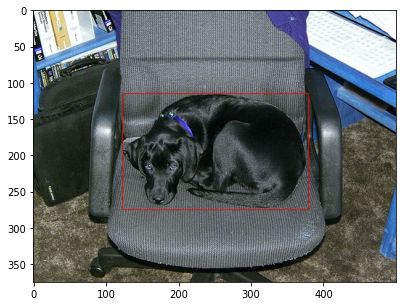

In [ ]:
# Example of single annotation.
plt.figure(figsize = (20, 5))
plt.imshow(cv2.rectangle(cv2.imread(os.path.join(IMG_DIR, annotations[0]['filename'])),
              (annotations[0]['bbox'][:2]),
              (annotations[0]['bbox'][2:]),
              color = (255, 0, 0)))

In [ ]:
img_resize = 224
num_classes = len(labels2idx.keys())

def tensorize_ground_truth(annotations):
    all_boxes = []
    all_cls = []
    for idx, annotation in enumerate(annotations):
        # Build a one-hot encoding of the class
        cls = np.zeros((num_classes))
        cls_idx = labels2idx[annotation['class']]
        cls[cls_idx] = 1.0

        coords = annotation['bbox']
        size = annotation['size']

        # Resize the image
        x1, y1, x2, y2 = (coords[0] * img_resize / size[0],
                          coords[1] * img_resize / size[1],
                          coords[2] * img_resize / size[0],
                          coords[3] * img_resize / size[1])

        # Compute center of the box and its height and width
        cx, cy = ((x2 + x1) / 2, (y2 + y1) / 2)
        w = x2 - x1
        h = y2 - y1
        boxes = np.array([cx, cy, w, h])
        all_boxes.append(boxes)
        all_cls.append(cls)

    # Stack everything into two big np tensors
    return np.vstack(all_cls), np.vstack(all_boxes)

In [ ]:
classes, boxes = tensorize_ground_truth(annotations)

In [ ]:
print(f'Classes shape: {classes.shape}, Boxes shape: {boxes.shape}')

Classes shape: (754, 5), Boxes shape: (754, 4)


## Interpreting output of model

Interpreting the output of the model is going from the output tensors to a set of classes (with confidences) and boxes corrdinates. It corresponds to reverting the previous preocess.

In [ ]:
def interpret_output(cls, boxes, img_size=(500, 333)):
    cls_idx = np.argmax(cls)
    confidence = cls[cls_idx]
    classname = idx2labels[cls_idx]
    cx, cy = boxes[0], boxes[1]
    w, h = boxes[2], boxes[3]

    small_box = [max(0, cx - w / 2), max(0, cy - h / 2),
                 min(img_resize, cx + w / 2), min(img_resize, cy + h / 2)]
    fullsize_box = [int(small_box[0] * img_size[0] / img_resize),
                    int(small_box[1] * img_size[1] / img_resize),
                    int(small_box[2] * img_size[0] / img_resize),
                    int(small_box[3] * img_size[1] / img_resize)]
    output = {'class': classname, 'confidence': confidence, 'bbox': fullsize_box}
    return output

Check the classes and boxes tensors of some known annotations.

In [ ]:
print(f'Original annotation:\n {annotations[0]}')
print(f'Interpreted output:\n {interpret_output(classes[0], boxes[0], img_size=annotations[0]["size"])}')

Original annotation:
 {'size': (500, 375), 'filename': '2007_000063.jpg', 'class': 'dog', 'bbox': [123, 115, 379, 275]}
Interpreted output:
 {'class': 'dog', 'confidence': 1.0, 'bbox': [123, 114, 379, 275]}


## Intersection over Union (Bounding Box tightness)

AKA **"Jaccard index"**

In order to assess the quality of our model, we will monitor the IoU between ground trith box and predicted box. The following function computes the IoU.

In [ ]:
def IoU(boxA, boxB):
    # Find the intersecting box coordinates
    x0 = max(boxA[0], boxB[0])
    y0 = max(boxA[1], boxB[1])
    x1 = min(boxA[2], boxB[2])
    y1 = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    inter_area = max(x1 - x0, 0) * max(y1 - y0, 0)

    # Compute the area of each box
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of areas minus the intersection areas
    return inter_area / float(boxA_area + boxB_area - inter_area)

Check the IoU of the bounding box of the original annotation with the bounding box of the interpretation of the resized version of the same annotation is close to $1.0$.

In [ ]:
original = annotations[0]
interpreted = interpret_output(classes[0], boxes[0], img_size=annotations[0]["size"])
print(f'IoU of the original versus the interpreted bounding box: {IoU(original["bbox"], interpreted["bbox"])}.')

IoU of the original versus the interpreted bounding box: 0.9937888198757764.


In [ ]:
def plot_IoU(boxA, boxB, img_size=(10, 10)):
    """Plot the IoU measure
    """
    iou = IoU(boxA, boxB)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_ylim(0, img_size[1])
    ax.set_xlim(0, img_size[0])
    ax.add_patch(plt.Rectangle((boxA[0], boxA[1]),
                               boxA[2] - boxA[0],
                               boxA[3] - boxA[1],
                               color='blue', alpha=0.5))
    ax.add_patch(plt.Rectangle((boxB[0], boxB[1]),
                               boxB[2] - boxB[0],
                               boxB[3] - boxB[1],
                               color='red', alpha=0.5))
    ax.set_title(f'IoU: {iou}')
    return fig, ax

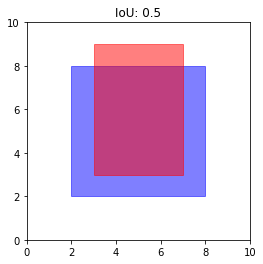

In [ ]:
fix, ax = plot_IoU([2, 2, 8, 8], [3, 3, 7, 9])
plt.show()

## Classification and Localisation model

We build a two headed model for classification and localisation.

In [ ]:
def classif_local_stupid_model(num_classes):
    """Stupid model that averages all the spatial information

    The goal of this model is to show that it's a very bad idea to destroy
    the spatial information with GlobalAveragePooling2D layer if our
    goal is to do object localization.
    """
    model_input = Input(shape=(7, 7, 2048))
    x = GlobalAveragePooling2D()(model_input)
    x = Dropout(0.2)(x)
    x = Dense(1000)(x)
    head_classes = Dense(num_classes, activation='softmax', name='head_classes')(x)
    head_boxes = Dense(4, name='head_boxes')(x)

    model = Model(inputs=model_input, outputs=[head_classes, head_boxes], name='resnet_loc')
    model.compile(optimizer='adam', loss=[categorical_crossentropy, mean_squared_error],
                  loss_weights=[1., 0.01])
    return model

In [ ]:
model = classif_local_stupid_model(num_classes)

Let's debug the model: select only a few examples and test the model before training with random weights.

In [ ]:
num = 64
inputs = reprs[0:num]
out_cls, out_boxes = classes[0:num], boxes[0:num]

print(f'Input batch shape: {inputs.shape}')
print(f'Ground truth batch shapes: {out_cls.shape} and {out_boxes.shape}')

Input batch shape: (64, 7, 7, 2048)
Ground truth batch shapes: (64, 5) and (64, 4)


In [ ]:
out = model.predict(inputs)
print(f'Output model batch shapes: {out[0].shape} and {out[1].shape}')

2/2 [==============================] - 0s 19ms/step
Output model batch shapes: (64, 5) and (64, 4)


Now, check whether the loss decreases and eventually if we are able to overfit on these few examples for debugging purpose.

In [ ]:
history = model.fit(inputs, [out_cls, out_boxes], batch_size=10, epochs=10)

Epoch 1/10
7/7 [==============================] - 1s 28ms/step - loss: 77.9654 - head_classes_loss: 19.7192 - head_boxes_loss: 5824.6172
Epoch 2/10
7/7 [==============================] - 0s 27ms/step - loss: 36.1876 - head_classes_loss: 8.1294 - head_boxes_loss: 2805.8130
Epoch 3/10
7/7 [==============================] - 0s 25ms/step - loss: 28.3575 - head_classes_loss: 5.6807 - head_boxes_loss: 2267.6782
Epoch 4/10
7/7 [==============================] - 0s 30ms/step - loss: 15.6924 - head_classes_loss: 2.6764 - head_boxes_loss: 1301.5928
Epoch 5/10
7/7 [==============================] - 0s 26ms/step - loss: 13.0096 - head_classes_loss: 0.6596 - head_boxes_loss: 1234.9956
Epoch 6/10
7/7 [==============================] - 0s 29ms/step - loss: 9.4273 - head_classes_loss: 0.5846 - head_boxes_loss: 884.2668
Epoch 7/10
7/7 [==============================] - 0s 26ms/step - loss: 8.1419 - head_classes_loss: 0.2206 - head_boxes_loss: 792.1328
Epoch 8/10
7/7 [==============================] - 0

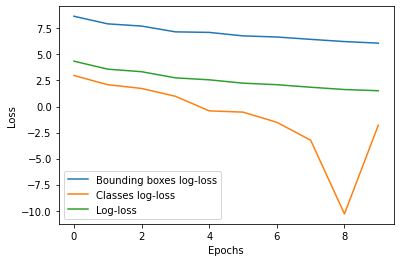

In [ ]:
plt.plot(np.log(history.history["head_boxes_loss"]), label="Bounding boxes log-loss")
plt.plot(np.log(history.history["head_classes_loss"]), label="Classes log-loss")
plt.plot(np.log(history.history["loss"]), label="Log-loss")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

## Displaying images and bounding box

In order to display our annotations, we build the function `plot_annotations` as follows:
* display the image
* display on top annotations and ground truth bounding boxes and classes

The `display` function:
* takes a single index and computes the result of the model
* interpret the ouput of the model as a bounding box
* calls the `plot_annotations` function

In [ ]:
def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2] - bbox[0] + 1, bbox[3] - bbox[1] + 1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    axis.text(bbox[0], bbox[1], display_txt, color='white', bbox={'facecolor':color, 'alpha':0.5})

def plot_annotations(img_path, annotation=None, ground_truth=None):
    img = imread(img_path)
    plt.imshow(img)
    current_axis = plt.gca()
    if ground_truth:
        text = "GT " + ground_truth["class"]
        patch(current_axis, ground_truth["bbox"], text, "red")
    if annotation:
        conf = f'{annotation["confidence"]:0.2f} '
        text = conf + annotation["class"]
        patch(current_axis, annotation["bbox"], text, "blue")
    plt.axis('off')

def display(model, index, ground_truth=True):
    res = model.predict(reprs[index][np.newaxis])
    output = interpret_output(res[0][0], res[1][0], img_size=annotations[index]["size"])
    plot_annotations(IMG_DIR + annotations[index]["filename"],
                     output, annotations[index] if ground_truth else None)

Let's display the predictions of the model and the ground truth annotation for a couple of images in our tiny debugging training set. The class should be right but the localization has little chance to be correct. The model has even more trouble on images that were not part of our tiny debugging training set.

1/1 [==============================] - 0s 24ms/step


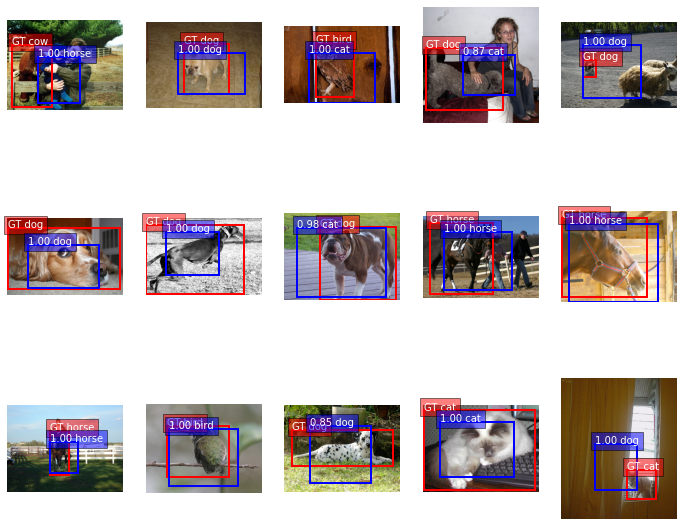

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    display(model, np.random.randint(reprs.shape[0]))
plt.show()

## Computing accuracy

For each example `(class_true, bbox_true)`, we consider it positive if and only if:
* the argmax of `output_class` of the model is `class_true`
* the IoU between the `output_bbox` and the `bbox_true` is above a threshold (usually $0.5$)

The accuracy of a model is then the number of positive divided be the total number. The following functions compute the class accuracy, IoU average and global accuracy.

In [ ]:
def accuracy_and_iou(preds, trues, threshold=0.5):
    sum_valid, sum_accurate, sum_iou = 0, 0, 0
    num = len(preds)
    for pred, true in zip(preds, trues):
        iou_value = IoU(pred["bbox"], true["bbox"])
        if pred["class"] == true["class"] and iou_value > threshold:
            sum_valid = sum_valid + 1
        sum_iou = sum_iou + iou_value
        if pred["class"] == true["class"]:
            sum_accurate = sum_accurate + 1
    return sum_accurate / num, sum_iou / num, sum_valid / num

In [ ]:
def compute_acc(model, train=True):
    if train:
        beg, end = 0, (9 * len(annotations) // 10)
        split_name = "Train"
    else:
        beg, end = (9 * len(annotations)) // 10, len(annotations)
        split_name = "Test"
    res = model.predict(reprs[beg:end])
    outputs = []
    for index, (classes, boxes) in enumerate(zip(res[0], res[1])):
        output = interpret_output(classes, boxes,
                                  img_size=annotations[index]["size"])
        outputs.append(output)

    acc, iou, valid = accuracy_and_iou(outputs, annotations[beg:end],
                                       threshold=0.5)

    print(f'{split_name} acc: {acc:0.3f}, mean IoU: {iou:0.3f}, acc_valid: {valid:0.3f}')

In [ ]:
compute_acc(model, train=True)
compute_acc(model, train=False)

90/90 [==============================] - 1s 13ms/step
Train acc: 0.732, mean IoU: 0.453, acc_valid: 0.356
10/10 [==============================] - 0s 17ms/step
Test acc: 0.686, mean IoU: 0.370, acc_valid: 0.192


## Training on the whole dataset

We split out dataset into a train and a test dataset. Then, train the model on the whole training set.

In [ ]:
# Keep last examples for test
test_num = reprs.shape[0] // 10
train_num = reprs.shape[0] - test_num
test_inputs = reprs[train_num:]
test_cls, test_boxes = classes[train_num:], boxes[train_num:]
print(f'Length of the train set: {train_num}, length of the test set: {test_num}')

Length of the train set: 2862, length of the test set: 317


In [ ]:
model = classif_local_stupid_model(num_classes)

In [ ]:
batch_size = 32
inputs = reprs[0:train_num]
out_cls, out_boxes = classes[0:train_num], boxes[0:train_num]

history = model.fit(inputs, y=[out_cls, out_boxes],
                    validation_data=(test_inputs, [test_cls, test_boxes]),
                    batch_size=batch_size, epochs=20, verbose=2)

Epoch 1/20
90/90 - 4s - loss: 22.1248 - head_classes_loss: 3.9706 - head_boxes_loss: 1815.4243 - val_loss: 12.5988 - val_head_classes_loss: 2.9989 - val_head_boxes_loss: 959.9854 - 4s/epoch - 47ms/step
Epoch 2/20
90/90 - 4s - loss: 10.0475 - head_classes_loss: 1.4645 - head_boxes_loss: 858.3067 - val_loss: 10.6707 - val_head_classes_loss: 2.1632 - val_head_boxes_loss: 850.7432 - 4s/epoch - 41ms/step
Epoch 3/20
90/90 - 3s - loss: 9.0555 - head_classes_loss: 1.1115 - head_boxes_loss: 794.3986 - val_loss: 9.3657 - val_head_classes_loss: 1.8853 - val_head_boxes_loss: 748.0357 - 3s/epoch - 32ms/step
Epoch 4/20
90/90 - 3s - loss: 8.4656 - head_classes_loss: 1.1594 - head_boxes_loss: 730.6167 - val_loss: 10.0548 - val_head_classes_loss: 2.4019 - val_head_boxes_loss: 765.2885 - 3s/epoch - 32ms/step
Epoch 5/20
90/90 - 3s - loss: 8.4002 - head_classes_loss: 1.1131 - head_boxes_loss: 728.7050 - val_loss: 9.5845 - val_head_classes_loss: 2.0774 - val_head_boxes_loss: 750.7104 - 3s/epoch - 32ms/step

In [ ]:
compute_acc(model, train=True)
compute_acc(model, train=False)

90/90 [==============================] - 1s 13ms/step
Train acc: 0.952, mean IoU: 0.564, acc_valid: 0.656
10/10 [==============================] - 0s 12ms/step
Test acc: 0.862, mean IoU: 0.425, acc_valid: 0.374


1/1 [==============================] - 0s 43ms/step


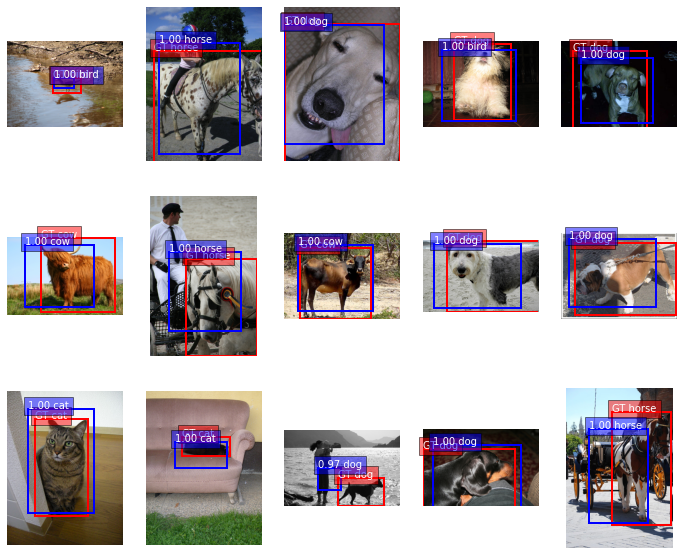

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    display(model, np.random.randint(reprs.shape[0]))
plt.show()

## Build a better model

In [ ]:
def classif_local_model(num_classes):
    model_input = Input(shape=(7, 7, 2048))
    x = GlobalAveragePooling2D()(model_input)
    x = Dropout(0.2)(x)
    x = Dense(1000)(x)
    head_classes = Dense(num_classes, activation='softmax', name='head_classes')(x)

    y = Convolution2D(4, (1, 1), activation='relu', name='hidden_conv')(model_input)
    y = Flatten()(y)
    y = Dropout(0.2)(y)
    head_boxes = Dense(4, name='head_boxes')(y)



    model = Model(inputs=model_input, outputs=[head_classes, head_boxes], name='resnet_loc')
    model.compile(optimizer='adam', loss=[categorical_crossentropy, 'mse'], loss_weights=[1., 1 / (224 * 224)])
    return model

In [ ]:
model = classif_local_model(num_classes)

In [ ]:
history = model.fit(inputs, y=[out_cls, out_boxes],
                    validation_data=(test_inputs, [test_cls, test_boxes]),
                    batch_size=batch_size, epochs=20, verbose=2)

Epoch 1/20
90/90 - 4s - loss: 7.3393 - head_classes_loss: 7.2461 - head_boxes_loss: 4673.0190 - val_loss: 3.4315 - val_head_classes_loss: 3.3973 - val_head_boxes_loss: 1718.4897 - 4s/epoch - 46ms/step
Epoch 2/20
90/90 - 3s - loss: 1.6847 - head_classes_loss: 1.6497 - head_boxes_loss: 1758.2841 - val_loss: 2.2711 - val_head_classes_loss: 2.2448 - val_head_boxes_loss: 1321.8074 - 3s/epoch - 35ms/step
Epoch 3/20
90/90 - 3s - loss: 1.0244 - head_classes_loss: 0.9973 - head_boxes_loss: 1361.7717 - val_loss: 2.1181 - val_head_classes_loss: 2.0957 - val_head_boxes_loss: 1123.7668 - 3s/epoch - 35ms/step
Epoch 4/20
90/90 - 3s - loss: 0.8225 - head_classes_loss: 0.8016 - head_boxes_loss: 1045.5759 - val_loss: 1.8437 - val_head_classes_loss: 1.8266 - val_head_boxes_loss: 857.8971 - 3s/epoch - 35ms/step
Epoch 5/20
90/90 - 3s - loss: 0.7311 - head_classes_loss: 0.7141 - head_boxes_loss: 854.7774 - val_loss: 1.8834 - val_head_classes_loss: 1.8681 - val_head_boxes_loss: 767.5721 - 3s/epoch - 35ms/ste

In [ ]:
compute_acc(model, train=True)
compute_acc(model, train=False)

90/90 [==============================] - 1s 15ms/step
Train acc: 0.977, mean IoU: 0.676, acc_valid: 0.822
10/10 [==============================] - 0s 14ms/step
Test acc: 0.865, mean IoU: 0.483, acc_valid: 0.465


1/1 [==============================] - 0s 17ms/step


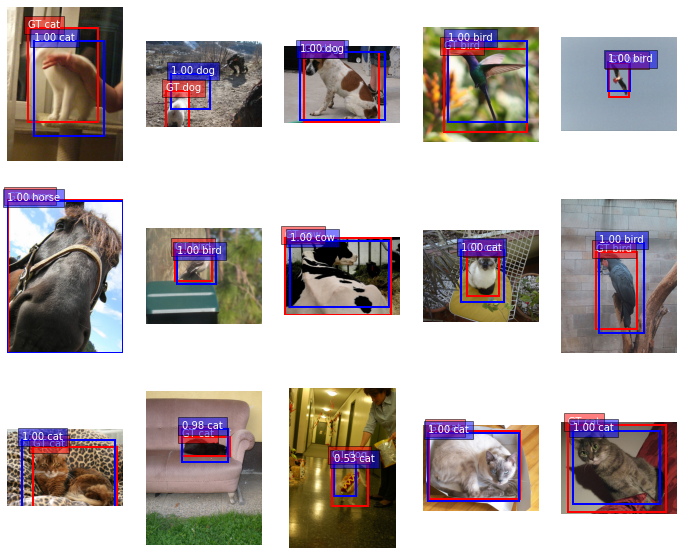

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    display(model, np.random.randint(reprs.shape[0]))
plt.show()